# GMM and EM
Gaussian Mixture Models and Expectation Maximization  

Here we show canned and homgrown implementations.

## Using a library call
Follow tutorial in [mastery](https://machinelearningmastery.com/expectation-maximization-em-algorithm/)

Use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class GaussianMixture.

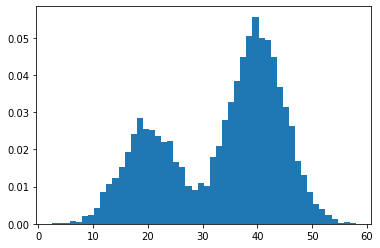

In [1]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [2]:
def show_gmm(model):
    print(model)
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 
            'Cov=',model.covariances_[i])

In [3]:
# Straight from the Mastery site.
# Use EM to reverse engineer the model i.e. fit a GMM to the data.
from sklearn.mixture import GaussianMixture
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
# By default, covariance=‘full’: each component has its own general covariance matrix.
# Use 'spherical' (one variance per mean) since our data has only one feature.
# By default, init_params='kmeans'. Works much better than 'random'!
model = GaussianMixture(n_components=2, verbose=1, covariance_type='spherical')
model.fit(X)
show_gmm(model)

Initialization 0
Initialization converged: True
GaussianMixture(covariance_type='spherical', n_components=2, verbose=1)
Gaussian 0 mean= [20.15747048] wgt= 0.3369844149393125 Cov= 25.048064107569136
Gaussian 1 mean= [40.11800486] wgt= 0.6630155850606868 Cov= 25.12234430154206


In [4]:
yhat = model.predict(X)
print('Predicted class of a point on the left:',yhat[100])
print('Predicted class of a point on the right:',yhat[-100])

Predicted class of a point on the left: 0
Predicted class of a point on the right: 1


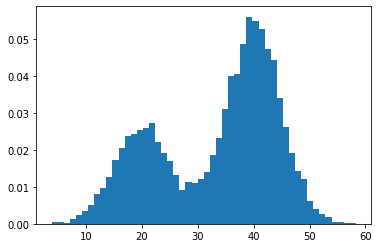

In [5]:
mean0=model.means_[0]
mean1=model.means_[1]
G0 = normal(loc=mean0, scale=5, size=3000) 
G1 = normal(loc=mean1, scale=5, size=6000)
if mean0>mean1:
    G0 = normal(loc=mean0, scale=5, size=6000) 
    G1 = normal(loc=mean1, scale=5, size=3000)
plot(G0,G1)

## Homegrown version
See [YouTube](https://youtu.be/iQoXFmbXRJA) video by Victor Lavrenko,
especially minute 3:46.


In [16]:
import scipy.stats as ss
import numpy as np
def assign_probs(mean,stdev,data):
    dist = ss.norm(mean,stdev)
    probs=np.asarray([dist.pdf(x) for x in data])
    return probs
def bayes(prob_under_this,prob_under_other,prior_for_this,):
    prior_for_other = 1-prior_for_this
    numerator = prob_under_this * prior_for_this
    denominator = numerator + prob_under_other * prior_for_other
    posterior = numerator / denominator
    return posterior
def assign_weights(probs1,probs2,prior1):
    prior2 = 1-prior1
    length = len(probs1)
    weights1=np.zeros(length)
    weights2=np.zeros(length)
    for i in range(length):    # do without for loop                  
        weights1[i]=bayes(probs1[i],probs2[i],prior1)  
        weights2[i]=bayes(probs2[i],probs1[i],prior2)  
    return weights1,weights2
def update_mean(weights,data):
    length = len(data)
    weighted=np.zeros(length)
    for i in range(length):   # do without for loop
        weighted[i]=data[i]*weights[i]  
    mean=sum(weighted)/sum(weights)
    return mean
def update_stdev(mean,weights,data):
    sse = 0
    for i in range(len(data)):   # do without for loop
        sse += ((mean-data[i])*weights[i])**2
    stdev=float(np.sqrt(sse/sum(weights)))
    return stdev
def iterative_2_means(mean1,mean2,data,num_iter):
    # initial guess is both equal to overall
    stdev1=np.std(data)
    stdev2=update_stdev(np.mean(data),np.ones(len(data)),data)  # should be same
    print('Initial means: %d +/- %d, %d +/- %d'%(mean1,stdev1,mean2,stdev2))
    prior1 = 0.5
    for i in range(num_iter):
        probs1=assign_probs(mean1,stdev1,data)
        probs2=assign_probs(mean2,stdev2,data)
        weights1,weights2 = assign_weights(probs1,probs2,prior1)
        mean1 = update_mean(weights1,data)
        mean2 = update_mean(weights2,data)
        stdev1 = update_stdev(mean1,weights1,data)
        stdev2 = update_stdev(mean2,weights2,data)
        print('Intermediate means: %d +/- %d, %d +/- %d'%(mean1,stdev1,mean2,stdev2))
    print()
    print('Final means: %d +/- %d, %d +/- %d'%(mean1,stdev1,mean2,stdev2))
    return mean1,mean2,stdev1,stdev2

In [17]:
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
guess1 = 40
guess2 = 50
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
mean1,mean2,stdev1,stdev2=iterative_2_means(guess1,guess2,X,20)

Initial means: 40 +/- 10, 50 +/- 10
Intermediate means: 30 +/- 9, 38 +/- 4
Intermediate means: 27 +/- 8, 40 +/- 2
Intermediate means: 27 +/- 8, 40 +/- 2
Intermediate means: 26 +/- 8, 41 +/- 2
Intermediate means: 26 +/- 7, 41 +/- 2
Intermediate means: 25 +/- 7, 41 +/- 3
Intermediate means: 24 +/- 6, 41 +/- 3
Intermediate means: 24 +/- 6, 41 +/- 3
Intermediate means: 23 +/- 6, 41 +/- 3
Intermediate means: 23 +/- 6, 41 +/- 3
Intermediate means: 22 +/- 5, 41 +/- 3
Intermediate means: 22 +/- 5, 40 +/- 4
Intermediate means: 21 +/- 5, 40 +/- 4
Intermediate means: 21 +/- 5, 40 +/- 4
Intermediate means: 21 +/- 5, 40 +/- 4
Intermediate means: 21 +/- 5, 40 +/- 4
Intermediate means: 21 +/- 4, 40 +/- 4
Intermediate means: 20 +/- 4, 40 +/- 4
Intermediate means: 20 +/- 4, 40 +/- 4
Intermediate means: 20 +/- 4, 40 +/- 4

Final means: 20 +/- 4, 40 +/- 4
